# Linear Models for Classification: The Perceptron

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur and updated by Ross Beveridge.

Last update 2/17/2022

**The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Labeled data - Review

Reminder:  A labeled dataset is a collection of feature vectors and their associated labels:

$$
\mathcal{D} = \{ \;(\mathbf{x}_i, y_i) \; \}_{i=1}^N
$$

where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i$ is the label associated with $\mathbf{x}_i$.
$\mathbb{R}^d$ is the set of all $d$-dimensional vectors with entries that are real numbers.

In this notebook we will focus on binary classification problems where  each example is classified into one of two classes.  Here we will use the labels $\{ -1, 1 \}$.

In [2]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, 
                          n_redundant=0, n_repeated=0, n_classes=2, 
                          n_clusters_per_class=1, class_sep=0.6, random_state=1)
X.shape, y.shape

((100, 2), (100,))

This data is **linearly separable**:  there exists a hyperplane defined by $(\mathbf{w}, b)$ that correctly classifies the data. To be even more descriptive, all of the positive samples fall on one side of the hyperplan (a line) and the negative samples on the other side.

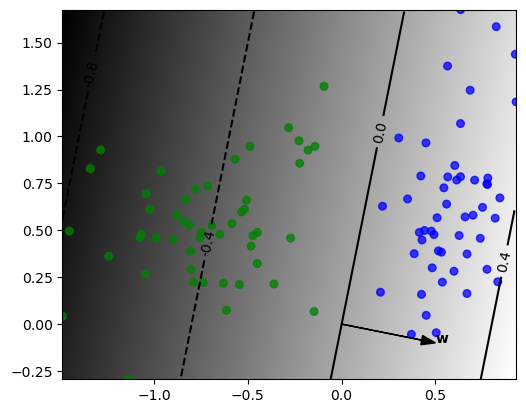

In [3]:
plt.style.use('default')
cols = ['g' if l == 1 else 'b' for l in y]
plt.scatter(X[:,0], X[:,1], c=cols, alpha=0.75, s=30, cmap='viridis');

w = np.array([0.5, -0.1])
b = 0
delta = 0.01
xmin=np.min(X[:,0]);xmax=np.max(X[:,0]);ymin=np.min(X[:,1]);ymax=np.max(X[:,1])
xs = np.arange(xmin, xmax, delta)
ys = np.arange(ymin, ymax, delta)
x_grid, y_grid = np.meshgrid(xs, ys)

Z = w[0] * x_grid + w[1] * y_grid + b
    
im = plt.imshow(Z, origin='lower',
                cmap=plt.cm.gray, extent=(xmin,xmax,ymin,ymax) )

C = plt.contour(x_grid, y_grid, Z, 3, origin='lower',
                colors = 'black')

plt.clabel(C, fmt='%1.1f')

plt.arrow(0,0,w[0],w[1], width=0.001,head_width=0.05, length_includes_head=True, alpha=1,linestyle='-',color='k');
plt.text(w[0], w[1], r"$\mathbf{w}$");


While not all datasets are linearly separable, we will start by considering algorithms designed explicitly to solve this simpler class of problems, e.g. linearly separable.
Also, we will focus on hyperplanes that go through the origin, i.e. $b=0$.

## The Perceptron Algorithm

The perceptron algorithm, proposed in 1958 by Frank Rosenblatt, is one of the first machine learning algorithms.  It is the precursor of neural networks.

**Idea:** iterate over the training examples, and update the weight vector $\mathbf{w}$ in a way that  makes $\mathbf{x}_i$  more likely to be correctly classified.

### Case 1: Positive Example Mis-classified

Let's assume $\mathbf{x}_i$ is a positive example that is incorrectly classified, i.e. $\mathbf{w}^\top \mathbf{x}_i < 0$.

Let's consider the update equation

$$
\mathbf{w}' = \mathbf{w} + \eta \mathbf{x}_i,
$$

where $1 > \eta > 0$ is a (small) positive number called the *learning rate*.

As we are about to show the following is true

$$
\mathbf{w}'^\top \mathbf{x}_i > \mathbf{w}^\top \mathbf{x}_i.
$$

This has the desired effect making $\mathbf{x}_i$ be more likely to be correctly classified.  This happens because the dot product of $\mathbf{x}_i$ with the weight vector is less likely to be negative after the update.

The derivation (below) is relatively simple and hinges upon the fact that $\mathbf{x}^\top \mathbf{x} > 0$

$$
\mathbf{w}'^\top \mathbf{x}_i = 
(\mathbf{w} + \eta \mathbf{x}_i)^\top  \mathbf{x}_i = 
\mathbf{w}^\top \mathbf{x}_i + \eta \mathbf{x}_i^\top  \mathbf{x}_i > \mathbf{w}^\top \mathbf{x}_i
$$

### Step Back - Think Through Some Basics

In deriving this inequality we relied on the following properties of the dot product:

* For any non-zero vector $\mathbf{x}$, we have that $\mathbf{x}^\top \mathbf{x} > 0$.
* For any vectors $\mathbf{u}, \mathbf{v}, \mathbf{w}$, we have that $(\mathbf{u} + \mathbf{v})^\top \mathbf{w} = \mathbf{u}^\top \mathbf{w} + \mathbf{v}^\top \mathbf{w}$

Using the definition of the dot product, verify that these properties hold.

### Case 2: A Negative Example Mis-Classified

If $\mathbf{x}_i$ is a negative example, the update needs to be in the opposite direction, since we want to make the dot product $\mathbf{w}^\top\mathbf{x}$ more negative.

Recall now that $y_i$ will be $-1$ in this case, so the following will change the sign of our previous update equation

$$
\mathbf{w}' = \mathbf{w} - \eta \mathbf{x}_i = \mathbf{w} + y_i \eta \mathbf{x}_i 
$$

More generally, the inclusion of $y_i$ as a multiplier to the update will do as we wish for both the positive and negative cases, giving us the following update equation: 

$$
\mathbf{w}' = \mathbf{w} + y_i \eta \mathbf{x}_i
$$

This leads us to the following algorithm:

`The perceptron algorithm`

**input:**  a labeled dataset

**output:** a weight vector $\mathbf{w}$.

```
initialize w=0
converged = False
while not converged :
    converged = True
    for i in 1,...,N :
        if x_i is misclassified update w and set
            converged=False
return w
```

Each iteration over the entire dataset is called an **epoch**.

Below we will create a Python class that implements this algorithm.

But first, let's write a function that generates linearly separable data in two dimensions:

In [4]:
def generate_separable_data(N) :
    epsilon = 0.05
    w = np.random.uniform(-1 , 1, 2)
    X = np.random.uniform(-1 + epsilon, 1 - epsilon, [N, 2])
    y = np.sign(np.dot(X, w))
    return X,y,w

In [5]:
X, y, w = generate_separable_data(10)
X.shape

(10, 2)

The following is a function to display the data and the weight vector:

In [6]:
def plot_data(X, y, w) :
    fig = plt.figure(figsize=(4,4))
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.arrow(0,0,w[0],w[1], width=0.001,head_width=0.05, 
              length_includes_head=True, alpha=1,
              linestyle='-',color='purple')
    a = -w[0]/w[1] # Slope of the line through origin
    pts = np.linspace(-1,1)
    plt.plot(pts, a*pts, 'k-')
    cols = {1: 'g', -1: 'b'}
    for i in range(len(X)): 
        plt.plot(X[i][0], X[i][1], cols[y[i]]+'o', alpha=0.6) 

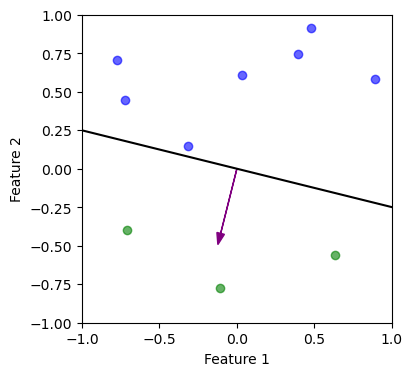

In [7]:
X,y,w = generate_separable_data(10)
plot_data(X, y, w)

And here's the Python class with the implementation of the perceptron:

In [8]:
class Perceptron :
 
    """An implementation of the perceptron algorithm.
    Note that this implementation does not include a bias term"""
 
    def __init__(self, iterations=100, learning_rate=0.2, 
                 plot_data=False) :
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.plot_data = plot_data
        # self.w = np.zeros(0)
        
    def fit(self, X, y) :
        """
        Train a classifier using the perceptron training algorithm.
        After training the attribute 'w' will contain the perceptron weight vector.
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
 
        y : ndarray, shape (n_examples,)
        Array of labels.
 
        """
        # self.w = np.zeros(len(X[0]))
        self.w = np.random.uniform(-1 , 1, 2)
        self.wold = self.w
        converged = False
        iterations = 0
        while (not converged and iterations <= self.iterations) :
            converged = True
            for i in range(len(X)) :
                if y[i] * self.decision_function(X[i]) <= 0 :
                    self.wold = self.w
                    self.w = self.w + y[i] * self.learning_rate * X[i]
                    converged = False
                    if self.plot_data:
                        self.plot_update(X, y, iterations, i)
            iterations += 1
        self.converged = converged
        if converged :
            print ('converged in %d iterations ' % iterations)
 
    def decision_function(self, x) :
        return np.dot(x, self.w)
 
    def predict(self, X) :
        """
        make predictions using a trained linear classifier
 
        Parameters
        ----------
 
        X : ndarray, shape (num_examples, n_features)
        Training data.
        """
 
        scores = np.dot(X, self.w)
        return np.sign(scores)
    
    def plot_update(self, X, y, icount, ipt) :
        fig = plt.figure(figsize=(4,4))
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        xlab = "F1 (i,pti): (" + str(icount) + "," + str(ipt) + ")"
        plt.xlabel(xlab)
        plt.ylabel("Feature 2")
        plt.arrow(0,0,self.w[0],self.w[1], 
                  width=0.001,head_width=0.05, 
                  length_includes_head=True, alpha=1,
                  linestyle='-',color='darkred')
        plt.arrow(0,0,self.wold[0],self.wold[1], 
                  width=0.001,head_width=0.05, 
                  length_includes_head=True, alpha=1,
                  linestyle='-',color='orange')
        anew = -self.w[0]/self.w[1]
        aold = -self.wold[0]/self.wold[1]
        pts = np.linspace(-1,1)
        plt.plot(pts, anew*pts, color='darkred')
        plt.plot(pts, aold*pts, color='orange')
        cols = {1: 'g', -1: 'b'}
        for i in range(len(X)): 
            plt.plot(X[i][0], X[i][1], cols[y[i]]+'o', alpha=0.6,markersize=5) 
        plt.plot(X[ipt][0], X[ipt][1], 'ro', alpha=0.2,markersize=20)
 


converged in 4 iterations 


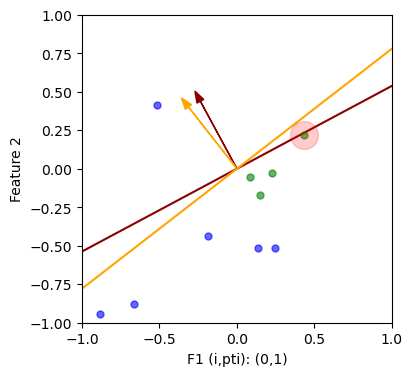

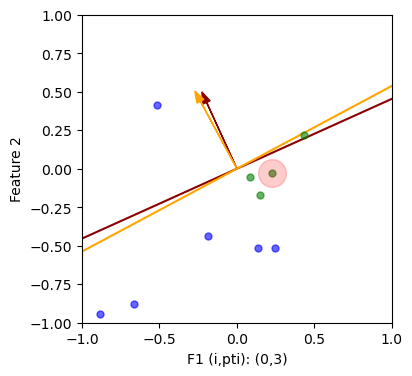

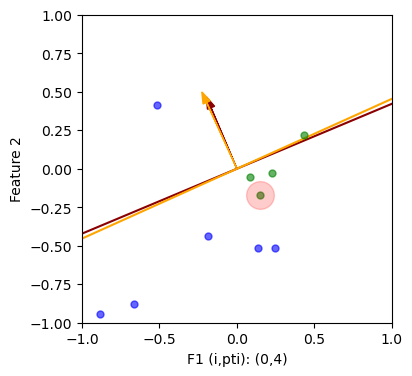

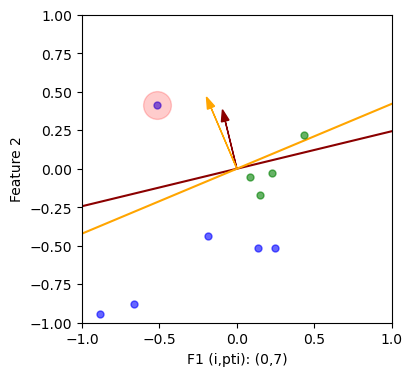

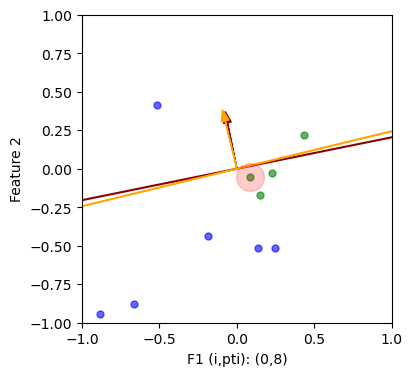

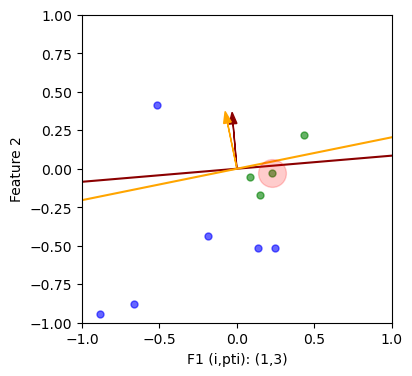

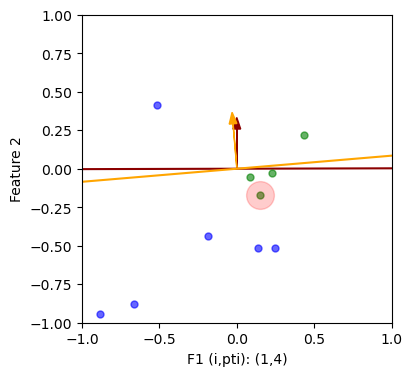

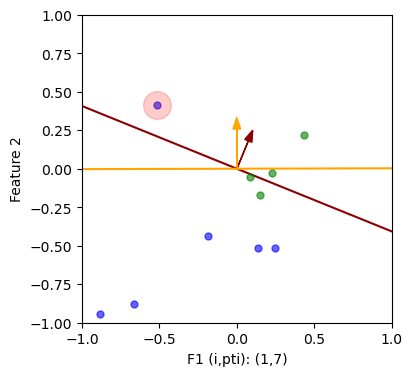

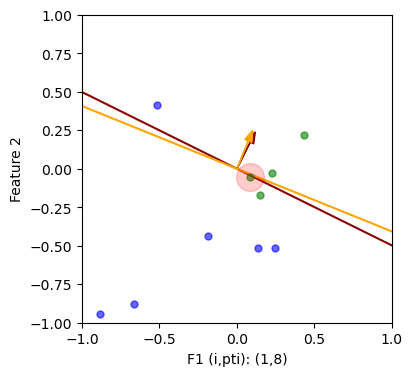

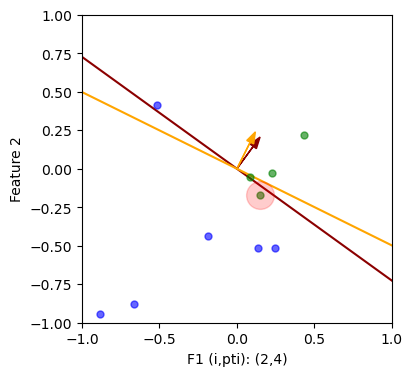

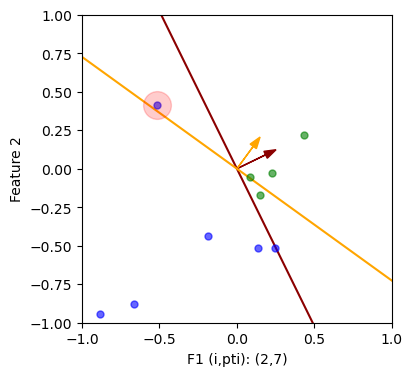

In [15]:
X,y,w = generate_separable_data(10)
p = Perceptron(plot_data=True)
p.fit(X,y)

### Experiment With Different Problem Instances

Use the code above to repeatedly look at how the decision boundar is moving.  To explain what you are seeing, the new decision boundary after an update is being shown in black.  The prior decision boundary is shown in yellow.  The specific point generating the update is shown with a red halo.  Keep in mind this point was found to fall on the wrong side of the decision boundary and the boundary is adjusted to hopefully (not assured) fall on the correct side of the boundary.  

The two integers printed in the horizontal axis label are important to track.  The first is the iteration of the algorithm counting from zero.  The second is the actual index of the point causing the update.  At first the counting of total iterations may seem in error - it is not.  Keep in mind that the last plotted update is in the iteration ahead of the one for which no updates are required.  Then, when counting iterations the final iteration with no changes is included. So, for example, if the last iteration count seen is 1 that still means that the total iterations is 2.

### About the Learned Decision Boundary

Let's compare the original weight vector that defined the class boundary to the weight vector learned by the Perceptron:

In [16]:
p.w, w

(array([0.25242662, 0.1233723 ]), array([0.43242515, 0.37713383]))

However, it may be hard to tell if these are similar by inspection. Next, let us normalize the two vectors into unit vectors:

In [17]:
print(p.w/np.sqrt(np.dot(p.w, p.w)))
print(w/np.sqrt(np.dot(w, w)))

[0.8984353  0.43910593]
[0.75364512 0.65728154]


Now we can see that they are pointing more or less in the same direction!

## Adding a Bias Term

Our algorithm as stated above has several limitations:

* The hyperplane goes through the origin.
* The algorithm doesn't converge if the data is not linearly separable.

To address the second limitation, all you need to do is add a limit on the number of iterations, which is what we did in the code.
To address the first, we'll show a trick for introducing a bias without actually having to modify the algorithm.  To do so, we'll modify the data instead.

Let's add another dimension to our weight vector, and a constant feature to our data:

$\tilde{\mathbf{w}}=[w_1,\ldots,w_d,w_{d+1}]^\top$

$\tilde{\mathbf{x}}= [x_1,\ldots,x_d,1]^\top$

With these definitions, you can easily verify that 

$$
\tilde{\mathbf{w}}^\top \tilde{\mathbf{x}} = \mathbf{w}^\top \mathbf{x}
+ w_{d+1}
$$

i.e. $w_{d+1}$ is equivalent to the bias term.

Why do we need to do the following?

In view of our discussion above, to implement a bias term all we need to do is add a column of ones to our feature matrix:

### Pros and cons of the perceptron

Here are some points in favor and against the perceptron:

####  Pros 

* Simple and easy to implement
* Relatively fast to train

#### Cons

Even with the fixes we made to the perceptron, there are still a couple of issues with the algorithm:

* Our algorithms contains several *hyperparameters*:  number of epochs, and learning rate.  It is not clear how to set those parameters.

* The solution bounces around and the algorithm chooses an arbitrary hyperplane that separates the two classes.  It may not be the best one from the learning perspective.

* Limited to linear decision boundaries.

* Limited to binary classification problems.

During the rest of this course we will learn algorithms that  address these issues in different ways.

### Linear classifiers

The perceptron is a simple algorithm for constructing linear decision boundaries.  Would we actually use it in practice?  Or more generally would we use linear algorithms in practice?  The answer is yes!  For the following reasons:

* A linear algorithm is a good baseline:  always start simple
* Linear models are stable
* Linear models are *less likely to overfit* the training data because they have less parameters.  
* Can sometimes *underfit*.  
* Often all you need when the data is high dimensional.
* Lots of scalable algorithms.

In summary, there is always a place for simple algorithms that can be trained quickly and give you a good idea of how hard a given classification problem is.

### The perceptron and the origins of artificial neural networks

Frank Rosenblatt who invented the algorithm did not initially intend for its use as a machine learning algorithm (a term that did not exist at the time):

> The perceptron program is not primarily concerned with the invention of devices for "artificial intelligence", but rather with investigating the physical structures and neurodynamic principles which underlie "natural intelligence." A perceptron is first and foremost a brain model, not an invention for pattern recognition.

The limitations of the simple version of the perceptron shown here were described in great detail in the book [Perceptrons: an introduction to computational geometry](https://en.wikipedia.org/wiki/Perceptrons_(book)) by Minsky and Pappert.  Publication of this book in 1969 lead many to conclude that work on artificial neural networks would be of little further use. It is worth noting that in hind sight Minsky and Pappert expressed some regret at this consequence. As we will see later this semester, whole Minsky and Pappert correctly identified a huge limitation of the Perceptron, they also clearly pointed a way forward where such limitations could be overcome.  

### References

* Rosenblatt, Frank. "The perceptron: a probabilistic model for information storage and organization in the brain." Psychological review 65.6 (1958): 386.